<a href="https://colab.research.google.com/github/rakesh-sengupta/vwm-change-detect/blob/main/Error_Rate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing set size: 2
Processing set size: 3
Processing set size: 4
Processing set size: 5
Processing set size: 6
Processing set size: 7
Processing set size: 8


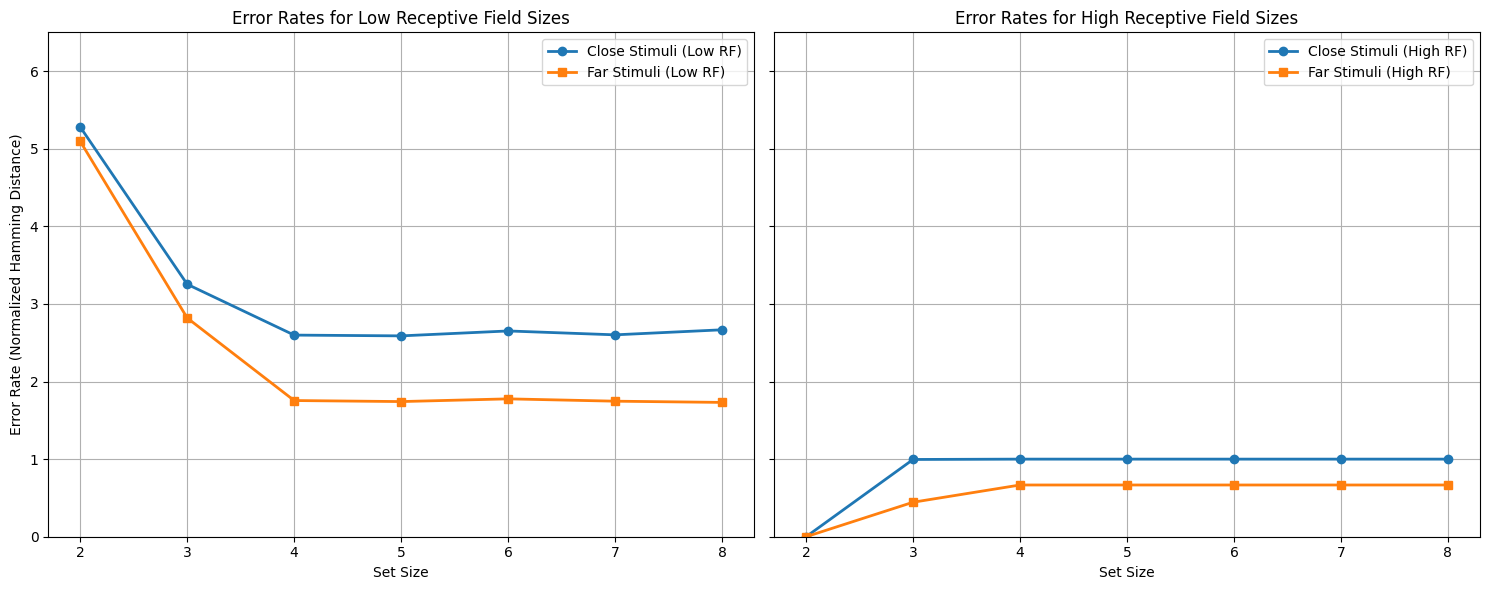

In [7]:
# Copyright (C) 2024 Rakesh Sengupta (Original Octave Code)
# Python version
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

import numpy as np
import matplotlib.pyplot as plt
import math

# Helper function to convert 1-based linear Octave index to 1-based (row, col)
# In Octave, indices are typically column-major.
# sub2ind(siz, row, col) -> (col-1)*siz(1) + row
# ind2sub(siz, ind) -> [row = rem(ind-1,siz(1))+1, col = floor((ind-1)/siz(1))+1]
def ind2sub_1based(linear_idx_1based, grid_dim_rows):
    """Converts a 1-based linear index to 1-based (row, col) subscripts for a grid,
    assuming column-major order like Octave/MATLAB."""
    if not (1 <= linear_idx_1based <= grid_dim_rows * grid_dim_rows): # Assuming square grid
        raise ValueError("Linear index is out of bounds.")
    col_1based = (linear_idx_1based - 1) // grid_dim_rows + 1
    row_1based = (linear_idx_1based - 1) % grid_dim_rows + 1
    return row_1based, col_1based

def sub2ind_1based(row_1based, col_1based, grid_dim_rows):
    """Converts 1-based (row, col) subscripts to a 1-based linear index,
    assuming column-major order."""
    if not (1 <= row_1based <= grid_dim_rows and 1 <= col_1based <= grid_dim_rows): # Assuming square grid
         raise ValueError("Subscripts are out of bounds.")
    return (col_1based - 1) * grid_dim_rows + row_1based

def generate_close_inputs(num_inputs, N):
    """
    Generate close input nodes radially around the center (3x3 central region).
    Python version using 0-based indexing for the output array I.
    """
    I = np.zeros(N)
    grid_dim = int(math.sqrt(N)) # Size of the grid (e.g., 8 for N=64)

    if grid_dim * grid_dim != N:
        raise ValueError("N must be a perfect square for grid operations.")

    # Center node in 1-based indexing (Octave: sub2ind([8, 8], 4, 4))
    # For an 8x8 grid, this is row 4, col 4.
    # Using a fixed center for an 8x8 grid as in the Octave example.
    # If grid_dim can change, this part might need to be more dynamic.
    if grid_dim == 8:
        center_r_1based, center_c_1based = 4, 4
    else:
        # Generic center (can be adjusted if non-8x8 grids are expected)
        center_r_1based = grid_dim // 2 + 1
        center_c_1based = grid_dim // 2 + 1

    center_node_1based = sub2ind_1based(center_r_1based, center_c_1based, grid_dim)

    # Define close region using 1-based linear indices relative to center_node_1based
    # These offsets correspond to one step in primary directions in a column-major grid
    # node_up    = center_node_1based - 1 (if center_node_1based > 1 and (center_node_1based-1-1)//grid_dim == (center_node_1based-1)//grid_dim )
    # node_down  = center_node_1based + 1 (if center_node_1based < N and ... )
    # node_left  = center_node_1based - grid_dim
    # node_right = center_node_1based + grid_dim

    potential_close_nodes_1based = []
    # Up (decrease row index)
    if center_r_1based > 1:
        potential_close_nodes_1based.append(sub2ind_1based(center_r_1based - 1, center_c_1based, grid_dim))
    # Down (increase row index)
    if center_r_1based < grid_dim:
         potential_close_nodes_1based.append(sub2ind_1based(center_r_1based + 1, center_c_1based, grid_dim))
    # Left (decrease col index)
    if center_c_1based > 1:
        potential_close_nodes_1based.append(sub2ind_1based(center_r_1based, center_c_1based - 1, grid_dim))
    # Right (increase col index)
    if center_c_1based < grid_dim:
        potential_close_nodes_1based.append(sub2ind_1based(center_r_1based, center_c_1based + 1, grid_dim))

    # Convert to 0-based indices for Python
    close_region_0based = [idx - 1 for idx in potential_close_nodes_1based]

    # Ensure unique selection and handle cases where num_inputs > available nodes
    num_to_select = min(num_inputs, len(close_region_0based))
    if num_to_select > 0 and len(close_region_0based) > 0 :
        selected_nodes_0based = np.random.choice(close_region_0based, size=num_to_select, replace=False)
        for node_idx in selected_nodes_0based:
            I[node_idx] = 1  # Set input to the selected nodes
    return I

def generate_far_inputs(num_inputs, N):
    """
    Generate far input nodes radially 3 units away from the center.
    Python version using 0-based indexing for the output array I.
    """
    I = np.zeros(N)
    grid_dim = int(math.sqrt(N))

    if grid_dim * grid_dim != N:
        raise ValueError("N must be a perfect square for grid operations.")

    if grid_dim == 8:
        center_r_1based, center_c_1based = 4, 4
    else:
        center_r_1based = grid_dim // 2 + 1
        center_c_1based = grid_dim // 2 + 1

    potential_far_nodes_1based = []
    distance = 3
    # Up by distance
    if center_r_1based - distance >= 1:
        potential_far_nodes_1based.append(sub2ind_1based(center_r_1based - distance, center_c_1based, grid_dim))
    # Down by distance
    if center_r_1based + distance <= grid_dim:
        potential_far_nodes_1based.append(sub2ind_1based(center_r_1based + distance, center_c_1based, grid_dim))
    # Left by distance
    if center_c_1based - distance >= 1:
        potential_far_nodes_1based.append(sub2ind_1based(center_r_1based, center_c_1based - distance, grid_dim))
    # Right by distance
    if center_c_1based + distance <= grid_dim:
        potential_far_nodes_1based.append(sub2ind_1based(center_r_1based, center_c_1based + distance, grid_dim))

    far_region_0based = [idx - 1 for idx in potential_far_nodes_1based]

    num_to_select = min(num_inputs, len(far_region_0based))
    if num_to_select > 0 and len(far_region_0based) > 0:
        selected_nodes_0based = np.random.choice(far_region_0based, size=num_to_select, replace=False)
        for node_idx in selected_nodes_0based:
            I[node_idx] = 1
    return I


def activation_function(x):
    """Activation function."""
    # Element-wise max(0, x / (1 + x))
    return np.maximum(0, x / (1 + x + 1e-9)) # Added epsilon to avoid division by zero if x = -1

def compute_distance_dependent_beta(N, beta_0, receptive_field_size):
    """Compute distance-dependent beta matrix."""
    beta_matrix = np.zeros((N, N))
    grid_dim = int(math.sqrt(N))

    if grid_dim * grid_dim != N:
        raise ValueError("N must be a perfect square for grid operations.")

    coords_1based = [ind2sub_1based(i + 1, grid_dim) for i in range(N)] # Get (r,c) for all nodes (1-based)

    for i in range(N):
        for j in range(N):
            if i == j:
                beta_matrix[i, j] = 0  # No self-inhibition
            else:
                r_i, c_i = coords_1based[i]
                r_j, c_j = coords_1based[j]

                # Euclidean distance
                delta_r = math.sqrt((r_i - r_j)**2 + (c_i - c_j)**2)

                # Distance-dependent inhibition
                beta_matrix[i, j] = beta_0 * math.exp(-delta_r**2 / (2 * receptive_field_size**2 + 1e-9)) # Epsilon for stability
    return beta_matrix

def simulate_network_and_compute_hamming(I_input, receptive_field_size, alpha, beta_0, dt, T_input, timesteps, noise_std):
    """Simulate the network and compute Hamming distance."""
    N = len(I_input)
    x = np.zeros(N)  # Initial state of nodes (1D array)
    # x_history = np.zeros((N, timesteps)) # To store the dynamics (not strictly needed for final Hamming distance)

    beta_matrix = compute_distance_dependent_beta(N, beta_0, receptive_field_size)

    # Simulate the dynamics
    for t_idx in range(int(timesteps)):
        noise = noise_std * np.random.randn(N)  # Gaussian noise (1D array)
        F_x = activation_function(x)  # Activation function for current state (1D array)

        # Apply transient input only for time <= T_input
        # (t_idx + 1) * dt is the time at the end of the current timestep
        if (t_idx + 1) * dt <= T_input:
            current_input = I_input
        else:
            current_input = np.zeros(N)

        # Update the state for each node (all are 1D arrays of size N)
        # beta_matrix @ F_x is matrix-vector product
        dx = -x + alpha * F_x - (beta_matrix @ F_x) + current_input + noise
        x = x + dx * dt  # Euler integration

        # x_history[:, t_idx] = x # Store state if needed for other analyses

    # Calculate Hamming distance between input and final output
    final_output = (x > 0.5).astype(int)  # Binarize output

    sum_I = np.sum(I_input)
    if sum_I == 0: # Avoid division by zero if no inputs were active (should not happen with set_sizes >=2)
        if np.sum(final_output) == 0: # No active inputs, no active outputs
            hamming_distance = 0.0
        else: # No active inputs, but some active outputs (all errors)
            hamming_distance = 1.0 # Or could be np.sum(final_output != I_input) / N if that's preferred
    else:
        # This is the Hamming distance normalized by the number of active inputs, as in original.
        hamming_distance = np.sum(final_output != I_input) / sum_I

    return hamming_distance

def average_hamming_distance(I_input_func, num_inputs_for_I, N_nodes, receptive_field_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations):
    """Calculate average Hamming distance over multiple simulations."""
    total_hamming_distance = 0
    for _ in range(num_simulations):
        # Generate new inputs for each simulation run
        I_current = I_input_func(num_inputs_for_I, N_nodes)
        if np.sum(I_current) == 0 and num_inputs_for_I > 0 : # Ensure inputs are generated if expected
             # This might happen if num_inputs > available locations for close/far stimuli
             # In this case, skip simulation or handle as error, here we'll get 0 hamming distance.
             # Or, one could argue the error is maximal if inputs were expected but not generated.
             # For simplicity, if I_current is all zeros, hamming_distance will likely be 0 or near 0.
             # The original code might implicitly handle this if randsample returns empty.
             pass # Let simulate_network_and_compute_hamming handle it.

        total_hamming_distance += simulate_network_and_compute_hamming(
            I_current, receptive_field_size, alpha, beta_0, dt, T_input, timesteps, noise_std
        )
    return total_hamming_distance / num_simulations


def error_rate_analysis_py():
    """Main error rate analysis function."""
    # Parameters
    N = 64  # Number of nodes (8x8 grid)
    # grid_size = int(math.sqrt(N)) # Size of the grid (derived where needed)
    dt = 0.01  # Time step
    T_total = 10  # Total simulation time
    T_input = 1  # Duration of input (transient)
    timesteps = T_total / dt  # Number of timesteps
    noise_std = 0.03  # Noise standard deviation
    alpha = 2.0  # Fixed value for alpha
    beta_0 = 0.3  # Standard value for beta
    num_simulations = 100  # Number of simulations for averaging (Original was 100, reduce for quick testing if needed)

    # Receptive field sizes
    low_receptive_field_sizes = [0.5, 1.0, 2.0]
    high_receptive_field_sizes = [4.0, 8.0, 16.0]

    # Set sizes to evaluate
    set_sizes = np.arange(2, 8 + 1)  # Number of inputs vary between 2-8

    error_rates_close_low = np.zeros(len(set_sizes))
    error_rates_far_low = np.zeros(len(set_sizes))
    error_rates_close_high = np.zeros(len(set_sizes))
    error_rates_far_high = np.zeros(len(set_sizes))

    # Loop through set sizes
    for i, num_inputs in enumerate(set_sizes):
        print(f"Processing set size: {num_inputs}") # Progress indicator

        # --- Low Receptive Field Sizes ---
        # Close stimuli
        errors_temp_close_low = [
            average_hamming_distance(generate_close_inputs, num_inputs, N, rf_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations)
            for rf_size in low_receptive_field_sizes
        ]
        error_rates_close_low[i] = np.mean(errors_temp_close_low)

        # Far stimuli
        errors_temp_far_low = [
            average_hamming_distance(generate_far_inputs, num_inputs, N, rf_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations)
            for rf_size in low_receptive_field_sizes
        ]
        error_rates_far_low[i] = np.mean(errors_temp_far_low)

        # --- High Receptive Field Sizes ---
        # Close stimuli
        errors_temp_close_high = [
            average_hamming_distance(generate_close_inputs, num_inputs, N, rf_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations)
            for rf_size in high_receptive_field_sizes
        ]
        error_rates_close_high[i] = np.mean(errors_temp_close_high)

        # Far stimuli
        errors_temp_far_high = [
            average_hamming_distance(generate_far_inputs, num_inputs, N, rf_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations)
            for rf_size in high_receptive_field_sizes
        ]
        error_rates_far_high[i] = np.mean(errors_temp_far_high)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    # Plot for low receptive field sizes
    axs[0].plot(set_sizes, error_rates_close_low, '-o', label='Close Stimuli (Low RF)', linewidth=2)
    axs[0].plot(set_sizes, error_rates_far_low, '-s', label='Far Stimuli (Low RF)', linewidth=2)
    axs[0].set_xlabel('Set Size')
    axs[0].set_ylabel('Error Rate (Normalized Hamming Distance)')
    axs[0].set_title('Error Rates for Low Receptive Field Sizes')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].set_ylim(0, 6.5)

    # Plot for high receptive field sizes
    axs[1].plot(set_sizes, error_rates_close_high, '-o', label='Close Stimuli (High RF)', linewidth=2)
    axs[1].plot(set_sizes, error_rates_far_high, '-s', label='Far Stimuli (High RF)', linewidth=2)
    axs[1].set_xlabel('Set Size')
    # axs[1].set_ylabel('Error Rate (Hamming Distance)') # Shared Y-axis
    axs[1].set_title('Error Rates for High Receptive Field Sizes')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 6.5)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set a seed for reproducibility if desired
    # np.random.seed(42)
    error_rate_analysis_py()

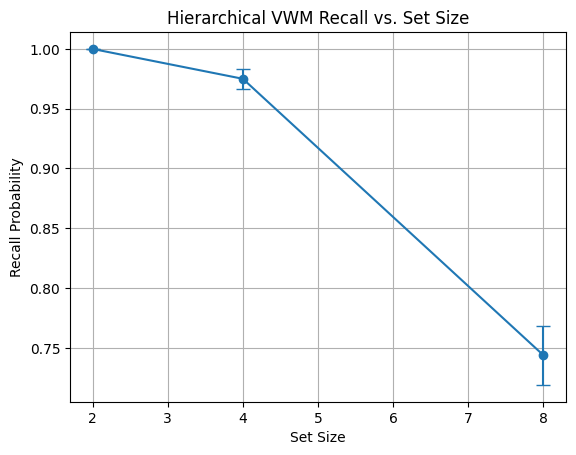

In [5]:
import numpy as np
import matplotlib.pyplot as plt

############################
# 1. Utility Functions
############################

def gaussian_tuning(preferred, stimulus, sigma_f=1.0):
    """
    Gaussian tuning function for feature selectivity.
    preferred: the neuron's preferred feature value (scalar or array)
    stimulus: the stimulus feature value
    sigma_f: width of tuning
    """
    return np.exp(- (stimulus - preferred)**2 / (2 * sigma_f**2))

def cross_talk_function(A_L, B=5.0):
    """
    Cross-talk function:
    C(L) = A(L) * exp(-B*(1 - A(L))^2)
    where A(L) is the fraction of the p-lattice visible at feedback level L.
    B is a scaling constant.
    """
    return A_L * np.exp(-B * (1 - A_L)**2)

def p_lattice_coverage(L):
    """
    Define the fraction of the p-lattice visible at feedback level L.
    Here, L=1: 0.3; L=2: 0.7; L=3: 1.0.
    """
    coverage_map = {1: 0.3, 2: 0.7, 3: 1.0}
    return coverage_map.get(L, 1.0)

def distance_dependent_inhibition(N, grid_size, beta_0, sigma_d):
    """
    Build a distance-based inhibition matrix for an NxN grid.
    """
    beta_mat = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                xi, yi = divmod(i, grid_size)
                xj, yj = divmod(j, grid_size)
                d = np.sqrt((xi - xj)**2 + (yi - yj)**2)
                beta_mat[i, j] = beta_0 * np.exp(-d**2 / (2 * sigma_d**2))
    return beta_mat

def F(x):
    """
    Activation function: x/(1+x) for x>0, else 0.
    """
    out = np.zeros_like(x)
    pos = (x > 0)
    out[pos] = x[pos] / (1.0 + x[pos])
    return out

############################
# 2. Hierarchical VWM Simulation
############################

def hierarchical_vwm_sim(num_objects, set_size, grid_size=8,
                         alpha=2.0, beta_0=0.1, sigma_d=2.0,
                         dt=0.01, T_total=10.0, noise_std=0.02,
                         feedback_levels=[1,2,3], B=5.0):
    """
    Simulate a hierarchical VWM model with a p-lattice structure:
    Scene -> Object -> Feature.
    We assume two feature layers (orientation and size) each with N nodes.
    The cross-talk function modulates feature clarity from the object layer.

    Returns the recall probability (as a measure of performance).
    """
    N = grid_size * grid_size

    # Build inhibition matrix for feature layers
    beta_mat = distance_dependent_inhibition(N, grid_size, beta_0, sigma_d)

    # Initialize feature layer states (orientation and size)
    x_orient = np.zeros(N)
    x_size   = np.zeros(N)

    # Define preferred feature values across the grid (topographic mapping)
    preferred_orientation = np.linspace(0, 180, N)
    preferred_size = np.linspace(1, 10, N)

    # Generate stimuli for set_size objects from a pool of num_objects.
    chosen_objs = np.random.choice(num_objects, set_size, replace=False)
    stimuli_orientation = np.random.uniform(0, 180, set_size)
    stimuli_size = np.random.uniform(1, 10, set_size)

    # Determine feedback level (simulate variation in p-lattice coverage)
    L = np.random.choice(feedback_levels)
    A_L = p_lattice_coverage(L)
    c_talk = cross_talk_function(A_L, B)  # Cross-talk clarity factor

    timesteps = int(T_total / dt)

    # Simulation: Encode inputs for a fraction of time, then let dynamics evolve.
    # Encoding phase: first 30% of timesteps.
    for t in range(timesteps):
        noise_or = noise_std * np.random.randn(N)
        noise_sz = noise_std * np.random.randn(N)

        F_orient = F(x_orient)
        F_size = F(x_size)

        # During encoding, add feature inputs from objects.
        if t < timesteps * 0.3:
            # For each object, add Gaussian-tuned input to feature layers.
            for o in range(set_size):
                orient_input = gaussian_tuning(preferred_orientation,
                                               stimuli_orientation[o], sigma_f=10.0)
                size_input = gaussian_tuning(preferred_size,
                                             stimuli_size[o], sigma_f=3.0)
                # Scale inputs by cross-talk clarity.
                F_orient += c_talk * orient_input
                F_size   += c_talk * size_input

        # Recurrent dynamics with distance-dependent inhibition.
        dx_orient = -x_orient + alpha * F_orient - beta_mat.dot(F_orient) + noise_or
        dx_size   = -x_size + alpha * F_size - beta_mat.dot(F_size) + noise_sz

        x_orient += dx_orient * dt
        x_size   += dx_size * dt

    # At the end of simulation, assess recall by comparing final states to the inputs.
    recall_count = 0
    for o in range(set_size):
        orient_ref = gaussian_tuning(preferred_orientation,
                                     stimuli_orientation[o], sigma_f=10.0)
        size_ref = gaussian_tuning(preferred_size, stimuli_size[o], sigma_f=3.0)

        final_bin_or = (x_orient > 0.5)
        final_bin_sz = (x_size > 0.5)

        # Compute overlap between the final state and the reference pattern.
        orient_overlap = np.sum(final_bin_or == (orient_ref > 0.1)) / N
        size_overlap = np.sum(final_bin_sz == (size_ref > 0.1)) / N

        # Consider the object recalled if both overlaps exceed thresholds.
        if orient_overlap > 0.5 and size_overlap > 0.3:
            recall_count += 1

    recall_prob = recall_count / set_size
    return recall_prob

############################
# 3. Error Rate / Recall Analysis
############################

def run_recall_analysis():
    set_sizes = [2, 4, 8]
    runs_per_size = 100
    recall_means = []
    recall_stds = []

    for sz in set_sizes:
        rec_vals = []
        for _ in range(runs_per_size):
            rp = hierarchical_vwm_sim(num_objects=20, set_size=sz, grid_size=8,
                                        alpha=3.0, beta_0=0.1, sigma_d=2.0,
                                        dt=0.01, T_total=10.0, noise_std=0.02,
                                        feedback_levels=[1,2,3], B=5.0)
            rec_vals.append(rp)
        recall_means.append(np.mean(rec_vals))
        # Divide standard deviation by sqrt(runs_per_size) for SEM.
        recall_stds.append(np.std(rec_vals) / np.sqrt(runs_per_size))

    # Plot recall probability vs. set size with error bars.
    plt.figure()
    plt.errorbar(set_sizes, recall_means, yerr=recall_stds, fmt='-o', capsize=5)
    plt.xlabel("Set Size")
    plt.ylabel("Recall Probability")
    plt.title("Hierarchical VWM Recall vs. Set Size")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_recall_analysis()
